# 1. Install Dependencies and Setup

In [1]:
print("Hello, world!")

Hello, world!


In [2]:
import tensorflow as tf
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from keras import backend as k, regularizers
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization

In [3]:
# set hyperprameters and top-level variables
data_dir = 'data3'
imgsize = 325
batchsize = 16
max_epochs = 64
wght_decay = 0.00005
learning_rate = 0.01
learning_decay = 1e-06
learning_drop = 20
learning_momentum = 0.9
epsilon = 1e-08

In [4]:
# # Hide the GPU - forces CPU training
# tf.config.set_visible_devices([], 'GPU')

In [5]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
   tf.config.experimental.set_memory_growth(gpu, True)
   #tf.config.experimental.set_virtual_device_configuration(gpu, [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=8192)])

In [6]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 3. Load and Scale Data

In [7]:
data = tf.keras.utils.image_dataset_from_directory(data_dir, batch_size=batchsize, image_size=(imgsize, imgsize))

Found 950 files belonging to 2 classes.


In [8]:
data = data.map(lambda x,y: (x/255, y))

In [9]:
# take a look at the data
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

In [10]:
batch[0].shape

(16, 325, 325, 3)

In [11]:
batch[0][0]

array([[[0.00784314, 0.00784314, 0.        ],
        [0.00784314, 0.00784314, 0.        ],
        [0.00467572, 0.00467572, 0.        ],
        ...,
        [0.02342379, 0.02734536, 0.0066453 ],
        [0.00392157, 0.00447059, 0.        ],
        [0.00392157, 0.00460068, 0.        ]],

       [[0.00784314, 0.00784314, 0.        ],
        [0.00784314, 0.00784314, 0.        ],
        [0.00467572, 0.00467572, 0.        ],
        ...,
        [0.01568628, 0.01960784, 0.        ],
        [0.01341176, 0.01733333, 0.        ],
        [0.01341176, 0.01733333, 0.        ]],

       [[0.00784314, 0.00784314, 0.        ],
        [0.00784314, 0.00784314, 0.        ],
        [0.00689291, 0.00689291, 0.        ],
        ...,
        [0.0145098 , 0.01843137, 0.        ],
        [0.01779737, 0.02171894, 0.        ],
        [0.01547449, 0.01939606, 0.        ]],

       ...,

       [[0.44951722, 0.4652035 , 0.5083408 ],
        [0.6908584 , 0.7065447 , 0.74968195],
        [0.5106637 , 0

In [12]:
batch[1]

array([1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0])

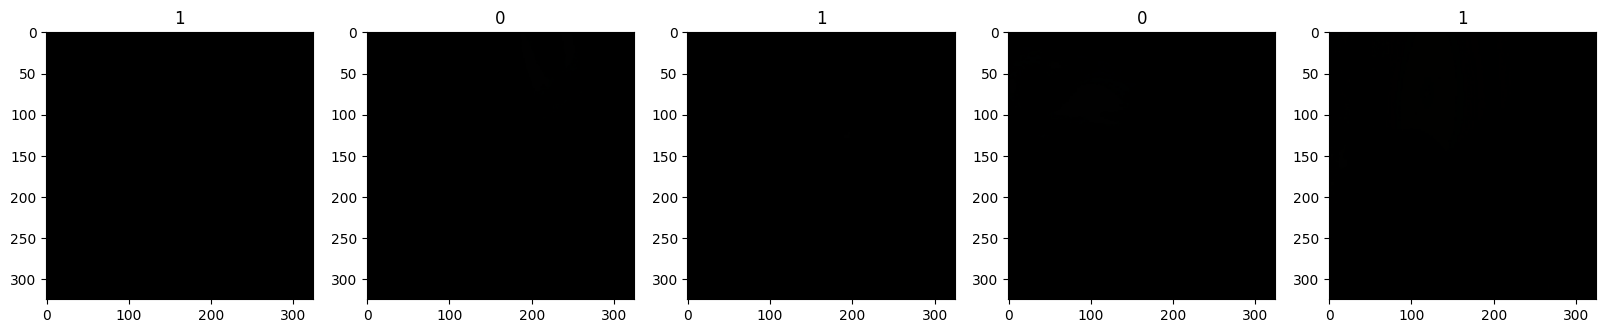

In [13]:
fig, ax = plt.subplots(ncols=5, figsize=(20,20))
for idx, img in enumerate(batch[0][:5]):
    ax[idx].imshow(img.astype(int))
    # ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

# 4. Split Data

In [14]:
len(data)

60

In [15]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [16]:
print("Train size: ", train_size)
print("Val size: ", val_size)
print("Test size: ", test_size)
print("Total size: ", train_size+val_size+test_size)

Train size:  42
Val size:  12
Test size:  6
Total size:  60


In [17]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [18]:
# for images, labels in train.take(1):  # only take first element of dataset
#     numpy_images = images.numpy()
#     numpy_labels = labels.numpy()

In [19]:
# numpy_images*255

In [20]:
# index=32
# plt.imshow(numpy_images[index])
# plt.xlabel(numpy_labels[index])
# plt.show()

# 5. Build Deep Learning Model

In [21]:
# function to determine rough model memory requirements
def get_model_memory_usage(batch_size, model):
    shapes_mem_count = 0
    internal_model_mem_count = 0
    for l in model.layers:
        layer_type = l.__class__.__name__
        if layer_type == 'Model':
            internal_model_mem_count += get_model_memory_usage(batch_size, l)
        single_layer_mem = 1
        out_shape = l.output_shape
        if type(out_shape) is list:
            out_shape = out_shape[0]
        for s in out_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([k.count_params(p) for p in model.trainable_weights])
    non_trainable_count = np.sum([k.count_params(p) for p in model.non_trainable_weights])

    number_size = 4.0
    if k.floatx() == 'float16':
        number_size = 2.0
    if k.floatx() == 'float64':
        number_size = 8.0

    total_memory = number_size * (batch_size * shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3) + internal_model_mem_count
    return gbytes

In [22]:
model = Sequential()

In [23]:
# initial setup
model.add(Conv2D(64, (3,3), 1, padding='same', activation='relu', input_shape=(imgsize,imgsize,3), kernel_regularizer=regularizers.l2(wght_decay)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# layers
model.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(wght_decay)))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(wght_decay)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(wght_decay)))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(wght_decay)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(wght_decay)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(wght_decay)))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(wght_decay)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(wght_decay)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(wght_decay)))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(wght_decay)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(wght_decay)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(wght_decay)))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(wght_decay)))
model.add(BatchNormalization())

model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [24]:
# set up the optimizer and compile the model
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-2,
#     decay_steps=10000,
#     decay_rate=0.9)
# optimizer = optimizers.sgd_experimental.SGD(learning_rate=lr_schedule)
optimizer = optimizers.gradient_descent_v2.SGD(learning_rate=learning_rate, decay=learning_decay, momentum=learning_momentum, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [25]:
# set up a weights checkpoint callback
filepath = os.path.join('models','weights.best.hdf5')
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 325, 325, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 325, 325, 64)     256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 325, 325, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 325, 325, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 325, 325, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 162, 162, 64)     0

In [27]:
# limit around 6GB???
get_model_memory_usage(batchsize, model)

4.654

# 6. Train

In [28]:
# logdir='logs'
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
# hist = model.fit(train, epochs=epochs, validation_data=val, callbacks=[tensorboard_callback])

In [29]:
# trained_model = model.fit_generator(image_augm.flow(x_train, y_train,
#     batch_size=batch_size),
#     steps_per_epoch=x_train.shape[0]//batch_size,
#     epochs=maxepoches,
#     validation_data=(x_test, y_test),callbacks=callbacks_list,verbose=1)

In [30]:
trained_model = model.fit(train, epochs=max_epochs, validation_data=val, callbacks=callbacks_list, verbose=1)

Epoch 1/64
42/42 [==============================] - ETA: 0s - loss: 0.3820 - accuracy: 0.6399
Epoch 1: val_accuracy improved from -inf to 0.55729, saving model to models\weights.best.hdf5
42/42 [==============================] - 16s 273ms/step - loss: 0.3820 - accuracy: 0.6399 - val_loss: 0.4751 - val_accuracy: 0.5573
Epoch 2/64
42/42 [==============================] - ETA: 0s - loss: 0.6097 - accuracy: 0.6443
Epoch 2: val_accuracy did not improve from 0.55729
42/42 [==============================] - 9s 212ms/step - loss: 0.6097 - accuracy: 0.6443 - val_loss: 1.1596 - val_accuracy: 0.4062
Epoch 3/64
42/42 [==============================] - ETA: 0s - loss: 17.7453 - accuracy: 0.4926
Epoch 3: val_accuracy did not improve from 0.55729
42/42 [==============================] - 9s 212ms/step - loss: 17.7453 - accuracy: 0.4926 - val_loss: 32.5559 - val_accuracy: 0.4167
Epoch 4/64
42/42 [==============================] - ETA: 0s - loss: 93.3663 - accuracy: 0.4732
Epoch 4: val_accuracy improved

KeyboardInterrupt: 

# 7. Plot Performance

In [ ]:
# plot loss
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot([None] + trained_model.history['loss'], 'o-')
ax.plot([None] + trained_model.history['val_loss'], 'x-')
ax.legend(['Training loss', 'Validation loss'], loc = 0)
ax.set_title('Training/Validation Loss per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

# fig = plt.figure()
# plt.plot(hist.history['loss'], color='teal', label='loss')
# plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
# plt.ylim(bottom=0)
# fig.suptitle('Loss', fontsize=20)
# plt.legend(loc="upper left")
# plt.show()

In [ ]:
# plot accuracy
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot([None] + trained_model.history['accuracy'], 'o-')
ax.plot([None] + trained_model.history['val_accuracy'], 'x-')
ax.legend(['Train acc', 'Validation acc'], loc = 0)
ax.set_title('Training/Validation Accuracy per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')

# fig = plt.figure()
# plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
# plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
# plt.ylim(0, 1)
# fig.suptitle('Accuracy', fontsize=20)
# plt.legend(loc="upper left")
# plt.show()

# 8. Evaluate

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [ ]:
print("-----------------------------------------------------")
print("Precision:       ", pre.result())
print("Recall:          ", re.result())
print("Binary Accuracy: ", acc.result())
print("-----------------------------------------------------")

# 9. Test

In [ ]:
img0 = cv2.imread('test/898.jpg')
img1 = cv2.imread('test/1241.jpg')
img2 = cv2.imread('test/1321.jpg')
img3 = cv2.imread('test/1367.jpg')
img4 = cv2.imread('test/1450.jpg')

img5 = cv2.imread('test/1547.jpg')
img6 = cv2.imread('test/1430.jpg')
img7 = cv2.imread('test/1436.jpg')
img8 = cv2.imread('test/1466.jpg')
img9 = cv2.imread('test/1515.jpg')

imgA = cv2.imread('data2/_FAPT/_t01.jpg')
imgB = cv2.imread('data2/_FAPT/_t02.jpg')
imgC = cv2.imread('data2/_FAPT/_t03.jpg')
imgD = cv2.imread('data2/_FAPT/_t04.jpg')
imgE = cv2.imread('data2/_FAPT/_t05.jpg')

In [ ]:
# plt.imshow(cv2.cvtColor(img0, cv2.COLOR_BGR2RGB))
# plt.show()

In [ ]:
resize0 = tf.image.resize(img0, (imgsize,imgsize))
resize1 = tf.image.resize(img1, (imgsize,imgsize))
resize2 = tf.image.resize(img2, (imgsize,imgsize))
resize3 = tf.image.resize(img3, (imgsize,imgsize))
resize4 = tf.image.resize(img4, (imgsize,imgsize))

resize5 = tf.image.resize(img5, (imgsize,imgsize))
resize6 = tf.image.resize(img6, (imgsize,imgsize))
resize7 = tf.image.resize(img7, (imgsize,imgsize))
resize8 = tf.image.resize(img8, (imgsize,imgsize))
resize9 = tf.image.resize(img9, (imgsize,imgsize))

resizeA = tf.image.resize(imgA, (imgsize,imgsize))
resizeB = tf.image.resize(imgB, (imgsize,imgsize))
resizeC = tf.image.resize(imgC, (imgsize,imgsize))
resizeD = tf.image.resize(imgD, (imgsize,imgsize))
resizeE = tf.image.resize(imgE, (imgsize,imgsize))

In [ ]:
# plt.imshow(resize0.numpy().astype(int))
# plt.show()
# plt.imshow(cv2.cvtColor(resize0, cv2.COLOR_BGR2RGB))
# plt.show()

In [ ]:
# img0

In [ ]:
# tf.shape(resize0)

In [ ]:
# resize0/255

In [ ]:
# tf.shape(numpy_images[0])

In [ ]:
# numpy_images[0]

In [ ]:
yhat0 = model.predict(np.expand_dims(resize0/255, 0))[0][0]
yhat1 = model.predict(np.expand_dims(resize1/255, 0))[0][0]
yhat2 = model.predict(np.expand_dims(resize2/255, 0))[0][0]
yhat3 = model.predict(np.expand_dims(resize3/255, 0))[0][0]
yhat4 = model.predict(np.expand_dims(resize4/255, 0))[0][0]

yhat5 = model.predict(np.expand_dims(resize5/255, 0))[0][0]
yhat6 = model.predict(np.expand_dims(resize6/255, 0))[0][0]
yhat7 = model.predict(np.expand_dims(resize7/255, 0))[0][0]
yhat8 = model.predict(np.expand_dims(resize8/255, 0))[0][0]
yhat9 = model.predict(np.expand_dims(resize9/255, 0))[0][0]

yhatA = model.predict(np.expand_dims(resizeA/255, 0))[0][0]
yhatB = model.predict(np.expand_dims(resizeB/255, 0))[0][0]
yhatC = model.predict(np.expand_dims(resizeC/255, 0))[0][0]
yhatD = model.predict(np.expand_dims(resizeD/255, 0))[0][0]
yhatE = model.predict(np.expand_dims(resizeE/255, 0))[0][0]

In [ ]:
index=25
# plt.imshow(numpy_images[index])
# plt.xlabel(numpy_labels[index])
# plt.show()
# yhatX = model.predict(np.expand_dims(numpy_images[index], 0))[0][0]
# print("{:.11f}".format(yhatX), " - Want ", numpy_labels[index])

In [ ]:
# model(np.expand_dims(resize0, 0))

In [ ]:
# model(np.expand_dims(numpy_images[index], 0))

In [ ]:
# model(numpy_images)

In [ ]:
print("{:.11f}".format(yhat0), " - Want 0.0")
print("{:.11f}".format(yhat1), " - Want 0.0")
print("{:.11f}".format(yhat2), " - Want 0.0")
print("{:.11f}".format(yhat3), " - Want 0.0")
print("{:.11f}".format(yhat4), " - Want 0.0")
print("------------------------")
print("{:.11f}".format(yhat5), " - Want 1.0")
print("{:.11f}".format(yhat6), " - Want 1.0")
print("{:.11f}".format(yhat7), " - Want 1.0")
print("{:.11f}".format(yhat8), " - Want 1.0")
print("{:.11f}".format(yhat9), " - Want 1.0")
print("------------------------")
print("{:.11f}".format(yhatA), " - Verify 1.0")
print("{:.11f}".format(yhatB), " - Verify 1.0")
print("{:.11f}".format(yhatC), " - Verify 1.0")
print("{:.11f}".format(yhatD), " - Verify 1.0")
print("{:.11f}".format(yhatE), " - Verify 1.0")

# 11. Save the Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save(os.path.join('models','imageclassifier.h5'))

In [ ]:
new_model = load_model(os.path.join('models', 'imageclassifier.h5'))

In [ ]:
yhatnew = new_model.predict(np.expand_dims(resize0/255, 0))

In [ ]:
yhatnew

# 12. Release Memory

In [ ]:
# from keras import backend as kbe
# kbe.clear_session()

In [ ]:
# from numba import cuda
# cuda.select_device(0)
# cuda.close()